Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* К сожалению проект требует небольших доработок. Однако, изменения не займут много времени.
* Также я добавил несколько советов. Пожалуйста, обрати на них внимание.
* Если возникнут вопросы, то задавай их в следующей ячейке. Жду новую версию проекта.

<div class="alert alert-block alert-warning">
Привет, спасибо за ревью) 
</div>

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После изменений проект улучшился и может быть зачтен.
* Радует, что ты овладел пайплайнами.
* Удачи в дальнейшем обучении и будущих работах!

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Содержание
* [Подготовка данных](#prepare_data)
  * [Изучение данных из файла](#prepare_data.open_file)
  * [Удаление ненужных столбцов](#prepare_data.remove_columns)
  * [Заполнение пропусков](#prepare_data.na_filling)
  * [Борьба с выбросами](#prepare_data.remove_outliers)
* [Обучение моделей](#model_train)
  * [Подготовка выборок](#model_train.split_data)
  * [CatBoost](#model_train.catboost)
  * [LightGBM](#model_train.lightgbm)
  * [Ridge](#model_train.ridge)
* [Анализ моделей](#model_analysis)

In [1]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
from collections import namedtuple

import time

RANDOM_STATE = 12345

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
ModelTimeAndRMSE = namedtuple('ModelTimeAndRMSE', ('fit_time', 'predict_time', 'rmse'))

In [3]:
def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()
    
def print_nan_percent(df):
    print('Пропуски')
    nan_columns = []
    
    for column in df.columns:
        nan_columns.append({
            'column': column, 
            'nan_count': df[column].isnull().sum(),
            'nan_percent': 100 * df[column].isnull().sum() / df.shape[0],
        })
    
    display(pd.DataFrame(nan_columns))
    
def plot_hist(df, column, bins=100): 
    df[column].plot(
        kind='hist', 
        bins=bins, 
        title=column,
        grid=True,
        figsize=(10,5),
    )

def print_zero_percent_in_column(df, column):
    zero_count = df[df[column] == 0].shape[0]
    print('Нулевых значений в {}: {}'.format(column, zero_count))
    print('% нулевых значений в {}: {:.2%}'.format(column, zero_count / df.shape[0]))
    
def get_model_time_and_rmse(model, features_train, target_train, features_test, target_test):
    fit_start = time.time()
    model.fit(features_train, target_train)
    fit_time = time.time() - fit_start
    
    predict_start = time.time()
    predictions = model.predict(features_test)
    predict_time = time.time() - predict_start
    
    rmse = mean_squared_error(target_test, predictions) ** 0.5
    
    return ModelTimeAndRMSE(fit_time, predict_time, rmse)

<a name="process_data"></a>
## Подготовка данных

<a name="prepare_data.open_file"></a>
### Изучение данных из файла

**Признаки**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *NotRepaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

In [4]:
autos_df = pd.read_csv('/datasets/autos.csv')
analyze_df(autos_df)

Количество стобцов: 16
Количество строк: 354369


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


**Выводы**: 
* присутствуют пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`
* есть бесполезные для предсказания стобцы `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`
* в столбцах `Price`, `Power` и `RegistrationYear` есть аномалии в значениях мнимального или максимального значения

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно.
</div>

<a name="prepare_data.remove_columns"></a>
### Удаление ненужных столбцов

Удалим бесполезные для предсказания цены столбцы `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`

In [5]:
autos_df = autos_df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode']) 

<div class="alert alert-block alert-success">
<b>Успех:</b> Согласен с удалением этих колонок. Они нам не нужны.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил удаление столбца PostalCode
</div>

<a name="prepare_data.na_filling"></a>
### Заполнение пропусков

In [6]:
print_nan_percent(autos_df)

Пропуски


,column,nan_count,nan_percent
0,Price,0,0.000000
1,VehicleType,37490,10.579368
2,RegistrationYear,0,0.000000
3,Gearbox,19833,5.596709
4,Power,0,0.000000
5,Model,19705,5.560588
6,Kilometer,0,0.000000
7,RegistrationMonth,0,0.000000
8,FuelType,32895,9.282697
9,Brand,0,0.000000


Поскольку не очень понятно, как заполнять эти пропуски заменим их на новую категорию "unkonwn"

In [7]:
for column in ('VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'):
    autos_df[column] = autos_df[column].fillna('unknown')

<div class="alert alert-block alert-success">
<b>Успех:</b> Запеолнить пропуски таким образом – допустимо.
</div>

<a name="prepare_data.remove_outliers"></a>
### Борьба с выбросами

Рассмотрим выбросы в `Power`

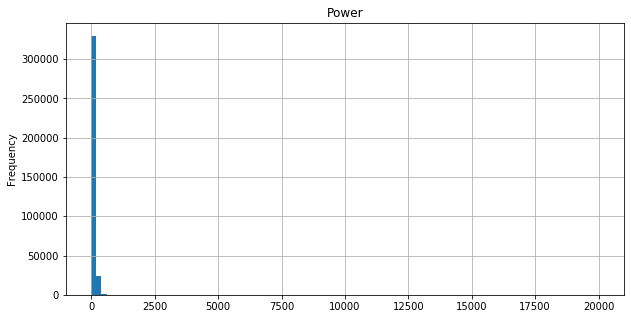

In [8]:
plot_hist(autos_df, 'Power')

Слишком большой разброс значений, возьмем 99.9 перцентиль и постоем график с ним

In [9]:
print(autos_df['Power'].quantile(0.999))

700.0


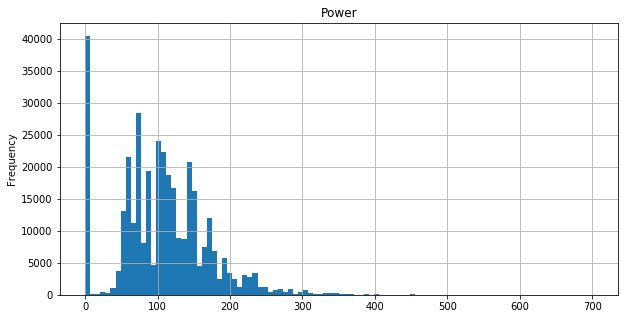

In [10]:
plot_hist(autos_df.query('Power <= 700'), 'Power')

Видно много нулевых значений, посмотрим сколько их 

In [11]:
print_zero_percent_in_column(autos_df, 'Power')

Нулевых значений в Power: 40225
% нулевых значений в Power: 11.35%


Самый [мощный автомобиль](https://www.autonews.ru/news/5dcab2409a7947da1459c059) на текущий момент - 2040 л.с. Избавимся от всех значений `Power` равных 0 и больше 2040

In [12]:
autos_df_power_outliers = autos_df.query('Power == 0 | Power > 2040')
print('Удалим все авто с мощностью равной 0 или больше 2040, их всего: {}'.format(autos_df_power_outliers.shape[0]))
print('В процентном соотношении: {:.2%}'.format(autos_df_power_outliers.shape[0] / autos_df.shape[0]))
autos_df = autos_df.query('Power > 0 & Power <= 2040')

Удалим все авто с мощностью равной 0 или больше 2040, их всего: 40332
В процентном соотношении: 11.38%


Рассмотрим выбросы в `RegistrationYear`

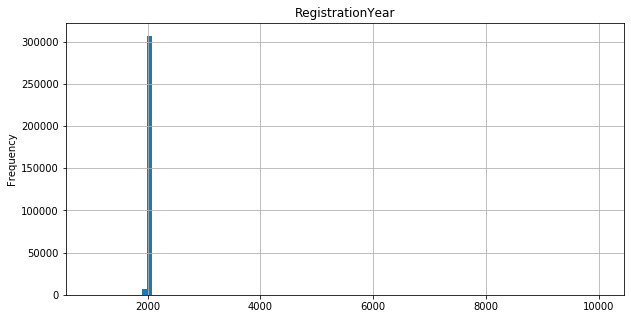

In [13]:
plot_hist(autos_df, 'RegistrationYear')

Возьмем за правую границу интервала текущий год (2020), а за левую дату создания первого автомобиля (1886), вдруг у нас на сайте есть и такие!

In [14]:
autos_df_year_outliers = autos_df.query('RegistrationYear < 1886 | RegistrationYear > 2020')
print('Удалим все авто с годом регистрации меньше 1886 или больше 2020, их всего: {}'.format(autos_df_year_outliers.shape[0]))
print('В процентном соотношении: {:.2%}'.format(autos_df_year_outliers.shape[0] / autos_df.shape[0]))
autos_df = autos_df.query('RegistrationYear >= 1886 & RegistrationYear <= 2020')

Удалим все авто с годом регистрации меньше 1886 или больше 2020, их всего: 42
В процентном соотношении: 0.01%


Рассмотрим выбросы в `Price`

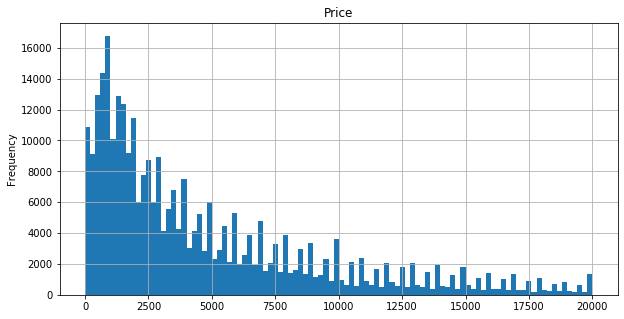

In [15]:
plot_hist(autos_df, 'Price')

Видим, что есть нули, посмотрим, сколько их

In [16]:
print_zero_percent_in_column(autos_df, 'Price')

Нулевых значений в Price: 6895
% нулевых значений в Price: 2.20%


Удалим все автомобили с нулевой ценой, непонятно, что с ними делать

In [17]:
autos_df_price_outliers = autos_df.query('Price == 0')
print('Удалим все авто с ценой равной 0, их всего: {}'.format(autos_df_price_outliers.shape[0]))
print('В процентном соотношении: {:.2%}'.format(autos_df_price_outliers.shape[0] / autos_df.shape[0]))
autos_df = autos_df.query('Price > 0')

Удалим все авто с ценой равной 0, их всего: 6895
В процентном соотношении: 2.20%


<div class="alert alert-block alert-success">
<b>Успех:</b> "Странные" значения обработаны корректно.
</div>

<a name="model_train"></a>
## Обучение моделей

<a name="model_train.split_data"></a>
### Подготовка выборок

Сначала выделим категориальные колонки

In [18]:
cat_features  = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']

<div class="alert alert-block alert-info">
<b>Совет: </b> Использовать PostalCode как числовой признак не очень корректно, а как категорильный также не очень получится, так как у него много уникальных значений. Его лучше было бы тоже удалить.
</div>

Выделим фичи и целевой показатель `Price`

In [19]:
features = autos_df.drop(columns=['Price'])
target = autos_df['Price']

Спрятанной тестовой выборки нет.  
Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую, размеры тестового и валидационного наборов обычно равны. 

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=RANDOM_STATE)

Заведем массив, в который мы будем помещать результаты работы моделей

In [21]:
models_stats = []

<a name="model_train.catboost"></a>
### CatBoost

In [22]:
model = CatBoostRegressor(random_seed=RANDOM_STATE, loss_function='RMSE', silent=True, cat_features=cat_features)

param_grid = {
    'learning_rate': [0.1, 0.01],
    'depth': [6, 8, 10],
    'iterations': [40, 60],
}

search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [23]:
%%time
search.fit(features_train, target_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 20.6min finished


CPU times: user 18min 31s, sys: 1min 22s, total: 19min 53s
Wall time: 21min 7s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f3ec8c85510>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': [0.1, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

Сохраним статистику для этой модели

In [24]:
stats = get_model_time_and_rmse(
    search.best_estimator_, 
    features_train, 
    target_train, 
    features_test, 
    target_test,
)

models_stats.append({
    'model': 'CatBoost',
    'fit_time': stats.fit_time, 
    'predict_time': stats.predict_time,
    'RMSE': stats.rmse,
})

<div class="alert alert-block alert-success">
<b>Успех:</b> Радует, что в данном случае использовался внутренний способ кодировки признаков, а для подбора параметров использовался grid search.
</div>

<a name="model_train.lightgbm"></a>
### LightGBM

Для LightGBM применим Label Encoding для категориальных колонок

In [25]:
encoder = LabelEncoder()

features_train_le = features_train.copy()
features_test_le = features_test.copy()

for df in (features_train_le, features_test_le): 
    df[cat_features] = df[cat_features].astype('category')

<div class="alert alert-block alert-info">
<b>Совет: </b> У модели lightGBM также существует внутренний механизм обработки категориальных признаков. Для этого достаточно изменить тип колонок с категориальными признаками на соответствующий: .astype('category').
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Переделал на тип category
</div>

In [26]:
model = LGBMRegressor(random_seed=RANDOM_STATE, silent=True)

param_grid = {
    'learning_rate': [0.01, 0.1],
    'depth':[6, 8, 10],
    'n_estimators': [60, 80, 100],
}

search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [27]:
%%time
search.fit(features_train_le, target_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 14.2min finished


CPU times: user 14min 7s, sys: 3.96 s, total: 14min 11s
Wall time: 14min 21s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_seed=12345,
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'learning_rate': [0.01, 0.1],
                         'n_estimators

Сохраним статистику для этой модели

In [28]:
stats = get_model_time_and_rmse(
    search.best_estimator_, 
    features_train_le, 
    target_train, 
    features_test_le, 
    target_test,
)

models_stats.append({
    'model': 'LightGBM',
    'fit_time': stats.fit_time, 
    'predict_time': stats.predict_time,
    'RMSE': stats.rmse,
})

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Пожалуйста, не ограничивайся одним классом моделей (град. бустинг над деревьями). Попробуй и другие модели. Например, линейные.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил модель Ridge
</div>

<a name="model_train.ridge"></a>
### Ridge

In [29]:
pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('model', Ridge(random_state=RANDOM_STATE))
])

param_grid = {
    'model__alpha': [20, 10, 5, 1, 0.1, 0.01, 0.001, 0],
}

search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [30]:
%%time
search.fit(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.8min finished


CPU times: user 4min 51s, sys: 59 ms, total: 4min 51s
Wall time: 4min 57s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(categorical_features=None,
                                                      categories=None,
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='ignore',
                                                      n_values=None,
                                                      sparse=True)),
                                       ('model',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=12345, solver='

In [31]:
stats = get_model_time_and_rmse(
    search.best_estimator_, 
    features_train, 
    target_train, 
    features_test, 
    target_test,
)

models_stats.append({
    'model': 'Ridge',
    'fit_time': stats.fit_time, 
    'predict_time': stats.predict_time,
    'RMSE': stats.rmse,
})

<a name="model_analysis"></a>
## Анализ моделей

In [32]:
display(pd.DataFrame(models_stats))

,model,fit_time,predict_time,RMSE
0,CatBoost,33.902267,0.435228,1739.152747
1,LightGBM,8.089641,1.305785,1635.504755
2,Ridge,9.736996,0.211630,2018.211638


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все показатели собраны в одной таблице. Так намного проще сравнивать.
</div>

**Выводы**:
* Качество моделей примерно одинаковое, RMSE у LightGBM слегка лучше за счет удачного подбора гиперпараметров
* Время обучения CatBoost в 5 раз хуже, чем у LightGBM, но зато скорость предсказаний лучше в 2.8 раз 
* Линейная модель Ridge дает худшее значение RMSE, но скорость предсказания лучше, чем у CatBoost
* Можно сделать вывод, что модели градиентного бустинга работают лучше, чем линейные

<div class="alert alert-block alert-success">
<b>Успех:</b> Сравнение проведено отлично.
</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей